In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils_laj import *
from data_processing import get_CMAPSSData, get_PHM08Data, data_augmentation, analyse_Data


In [ ]:
dataset = "cmapss" 

file = 1 # one value out of [1,2,3,4] must be chosen, 
         # which corresponds to the sub-dataset from cmapss (FD001-FD004) on which the model shall be trained
         

analyse_Data(dataset=dataset, files=[file], plot=False, min_max=False)

# the augmented dataset for the respective file gets created 
# details can be found in the "Data Augmentation" section of https://arxiv.org/pdf/1810.05644.pdf 
data_augmentation(files=file,
              low=[10, 35, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330],
              high=[35, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350],
              plot=False,
              combine=False)
    
# the data is loaded and the sensor channels are normalized (mean=0, std=1)
training_data, testing_data, training_pd, testing_pd = get_CMAPSSData(save=False)


In [ ]:
# "24" in the second dimension of the data corresponds to the number of features (sensor_values+settings)
# the value in the first component of the shape is the sum over the time steps of all samples

x_train = training_data[:, :training_data.shape[1] - 1]
y_train = training_data[:, training_data.shape[1] - 1]
print("training data CNNLSTM: ", x_train.shape, y_train.shape)

x_test = testing_data[:, :testing_data.shape[1] - 1]
y_test = testing_data[:, testing_data.shape[1] - 1]
print("testing data CNNLSTM: ", x_test.shape, y_test.shape)

# The Model 
The model takes a batch of shape **(batch_size,sequence_length,24)** where 24 corresponds to the number **input features (sensor values plus settings)** and the **sequence length is set to 100** (empirically determined).
<br>
Since the input and output time series on the other hand do not have a fixed length, the input for training and inference must be provided cleverly (which will be discussed later).
<br>
The **processing steps** of the model can be summarized as follows (and the details can be checked by looking at the model class in the next cell):
<br>

1. Feature extraction by temporal convolutions (Conv1d) and MaxPooling (==> temporal dimension is downsampled)
2. Upsampling of time dimension by first flattening the units:
**(batch_size,time,feats)==>(batch_size,time*feats)**,
applying a Dense Layer on the flattend array with appropriate output units so that a sequence of shape (batch_size,100,new_feats_dim) can be formed again.
3. Further feature extraction and information propagation along the time axis by LSTM layers.
4. Processing of the feature information for each time step separately by a sequence of Dense layers


For regularization classical Dropout layers are used.


In [10]:
class RulModel(tf.keras.Model):
    def __init__(self,in_dim):
        super().__init__()
        self.seq_len = 100
        self.n_channels = 24
        
        # Convolutions + Pooling opertations for feature extraction
        self.conv_1 = tf.keras.layers.Conv1D(18,2,strides=1,padding='same',activation = tf.nn.relu,name='conv_1')
        self.pool_1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2,padding='same',name='pool_1')
        self.conv_2 = tf.keras.layers.Conv1D(36,2,strides=1, padding='same',activation = tf.nn.relu,name='conv_2')
        self.pool_2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2,padding='same',name='pool_2')
        self.conv_3 = tf.keras.layers.Conv1D(72,2,strides=1, padding='same',activation = tf.nn.relu,name='conv_3')
        self.pool_3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2,padding='same',name='pool_3')
        # Due to the Pooling operations the time dimension got scaled downed during the previous steps
        # the dense layer is needed to upsample the tensor along the time axis again
        self.dense = tf.keras.layers.Dense(self.seq_len*self.n_channels,activation = tf.nn.relu,name='dense_1')
        self.rnn_1 = tf.keras.layers.LSTM(units=3*self.n_channels,dropout=0.2,return_sequences=True,name='lstm_1')
        self.rnn_2 = tf.keras.layers.LSTM(units=3*self.n_channels,return_sequences=True,name='lstm_2')
        
        self.process = tf.keras.layers.Dense(50,activation = tf.nn.relu,name='dense_2')
        self.out = tf.keras.layers.Dense(1,name='dense_3')
        
        self.drop_1 = tf.keras.layers.Dropout(0.2,name='drop_1')
        self.drop_2 = tf.keras.layers.Dropout(0.2,name='drop_2')
        self.drop_3 = tf.keras.layers.Dropout(0.2,name='drop_3')
        
    def call(self,inp): # input dimensions (batch_size,seq_len,features) resp. (None,100,24)
        x = self.conv_1(inp)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        x = self.pool_3(x)
        x = tf.keras.layers.Reshape((13*72,))(x)
        x = self.dense(x)
        x = tf.keras.layers.Reshape((self.seq_len,self.n_channels))(x)
        x = self.drop_1(x)
        x = self.rnn_1(x) 
        x = self.rnn_2(x) 
        x = self.drop_2(x)
        x = self.process(x)
        x = self.drop_3(x)
        x = self.out(x)
        
        return tf.squeeze(x,-1) # output dimensions (batch_size,seq_len,features) resp. (None,100)
    
model = RulModel(24)

As mentioned the **sequence length** is set to **100 independent of the true length** of the time series. One sample of a batch will be build as follows during training: 
<br> A random time step of a certain sequence is chosen as starting point. If the rest of the related sequence has at least 100 time steps, then this subsequence will form the sample. If ,on the other hand, less than 100 future steps remain for the considered sequence, then a subsequences of a new sequences will be used until the 100 time steps are reached. The corresponding procedure is also done for the target sample so that related input and output values are set to corresponding time steps in the sample.
<br>
This process will be done by the RulGenerator defined in the next cell, which will be used for training the model.

In [5]:
class RulGenerator(tf.keras.utils.Sequence):
    """Dataloader for batch generation."""
    def __init__(self,data,rul,batch_size=32,test=False):
        self.data = data
        self.targets = rul
        self.test = test
        self.batch_size = batch_size
        #self.indexes = np.arange(len(self.data))
        self.sequence_length = 100
        self.num_x_sensors  = data.shape[-1]
        self.on_epoch_end()
        self.idx = 0

    def __len__(self):
        return len(self.data)//(self.batch_size*self.sequence_length)

    def __getitem__(self, index):
        return self.generate_batch(index,test=self.test)

    def generate_batch(self,idx,test):
        x_train = self.data
        y_train = self.targets
        x_shape = (self.batch_size, self.sequence_length, self.num_x_sensors)
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)
        # Allocate a new array for the batch of output-signals.
        y_shape = (self.batch_size, self.sequence_length)
        y_batch = np.zeros(shape=y_shape, dtype=np.float32)

        # Fill the batch with random sequences of data.
        idx = self.batch_size*self.sequence_length*idx   
        for i in range(self.batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if 1-test:
                idx = np.random.randint(len(self.data)-self.sequence_length)
            if idx + self.sequence_length >= len(self.data):
                idx = 0

            x_batch[i] = x_train[idx:idx + self.sequence_length]
            y_batch[i] = y_train[idx:idx + self.sequence_length]
            idx += self.sequence_length

        return x_batch,y_batch
 

## Training

In [ ]:
# the generators for training and testing are defined 
train_generator = RulGenerator(x_train,y_train,test=False)
test_generator = RulGenerator(x_test,y_test,test=True)

In [ ]:
model = RulModel(x_train.shape[-1])
model.compile(loss='MSE',metrics=['MAE'],optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4))

In [ ]:
# Train model on dataset
model.fit(x=train_generator,validation_data=test_generator,epochs=35)

In [ ]:
model.save_weights(f'weights_model_{file}.h5')

## Inference

In [35]:
# loading a model for inference
file = 1
model = RulModel(24)
model.build(input_shape=(None,100,24))
model.load_weights(f'weights_model_{file}.h5')

In [36]:
# for testing we load the original test dataframe
file = 1
path = f'CMAPSSData/'
# the test data for the respective dataset/file is loaded
test_inp = get_CMAPSSData(save=True, save_training_data=True, save_testing_data=True, files=[file])
y_test = test_inp[1][:,-1]
test_inp = test_inp[1][:,:-1]
# the related RUL values are loaded
cols = ['unit', 'cycles', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df = pd.read_csv(path+f'test_FD00{file}.txt',header=None, delim_whitespace=True)
test_df.columns = cols
RUL = pd.read_csv(path+f'RUL_FD00{file}.txt', header=None, delim_whitespace=True)
RUL.columns = ['rul']    # RUL contains the target values  

train_FD001
test_FD001


**plot_Rul_vs_pred:**
<br>
This function is used for plotting the RUL prediction of the model and the related ground truth sample together in one plot.
<br>
For training the ground truth sample is clipped at a certain upper value (120 in our case). As mentioned in the README.md the authors claim that the basic assumption for this proceeding is that the engine has maximum health initally (corresponding to this clipping value) and mantains this health until a certain step at which the decay begins. This clipping is the reason for the shape of the ground truth values: A horizontal line which at some point in time typically falls linearly. You will see samples where a plot starts with a horizontal line, falls at some later point in time and goes back to "full health" (120) again. The reason for this are input samples with less than 100 time steps. The model has a fixed input length of 100 and thus you have to fill the "missing" time steps somehow. For inference copys of the currently considered time series are inserted for the first missing times steps instead of (e.g.) zero padding so that the samples are created according to the same criteria as the training samples. 
<br>
There may also appear examples where a the target is simply a horizontal line. This happens if the final RUL of the test sample is larger than the chosen clipping value (resp. 120). These cases are probably the main error source (which I will explain later).
<br> These plots are only for visualization. For getting the RMSE basically only the prediction with the largest x-value in the plots is relevant which corresponds to the RUL prediction at the latest point in time where we have sensor information. These values are compared with the ground truth values and finally used to calculate the RMSE. This implies that for the final score it does not matter if the ground truth plot and the prediction plot are completely different previous to this last steps (as long as they are close there). 
<br>
But also other options for determining the Rul values are thinkable: The applied model is build such that there is also information flow from future to past time steps. Thus, it might be reasonable to use also the predictions of previous times steps for creating a final prediction.
<br> 
Moreover, for obtaining the best possible score it is surely reasonable to adjust the clipping value (currently 120) for the respectively considered dataset. Since the model predicts only clipped values in training, it will not predict values (distinctly) larger than this clipping value. Thus, samples in the test set where the RUL is larger than 120 might lead to hugh errors and a metric like RMSE can be easily influenced by single outliers. For the actual use case, on the other hand, these errors are not really relevant because they are related to cases where the engine is still very "healthy". Hence, it might be reasonable to pay little attention to such errors and to judge the model performance with more focus on the cases where the engine is about to fail.

In [37]:
def plot_Rul_vs_pred(pred,y_true):
    plt.plot(pred,label='pred')
    plt.plot(y_true,label='ground truth')
    axes = plt.gca()
    axes.set_ylim([0,130])
    plt.suptitle('RUL pred vs target')
    plt.ylabel('(clipped) RUL')
    plt.xlabel('time steps')
    plt.legend()
    plt.show()

true RUL: 95


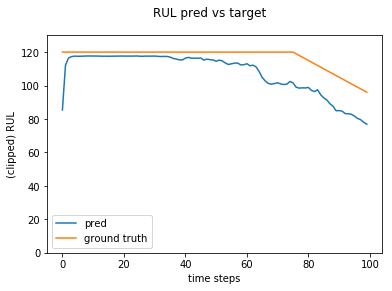

true RUL: 84


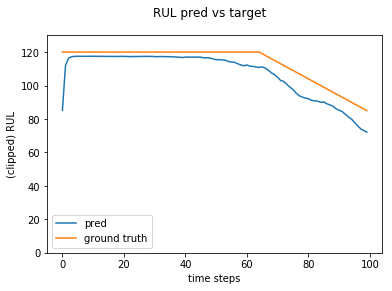

true RUL: 90


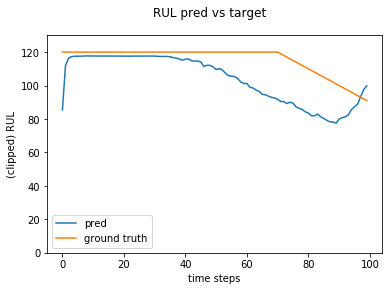

true RUL: 50


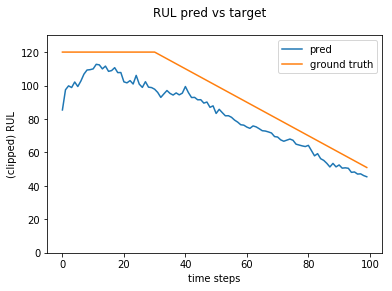

true RUL: 114


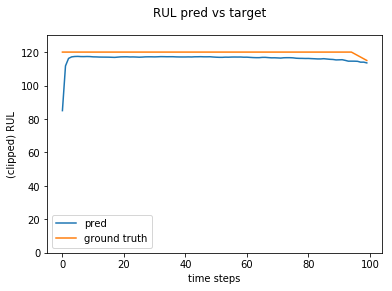

true RUL: 100


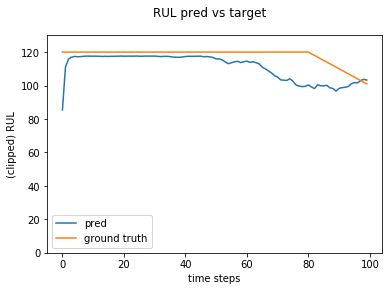

true RUL: 72


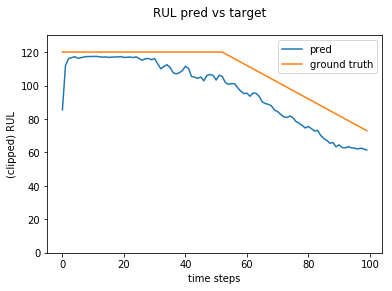

true RUL: 8


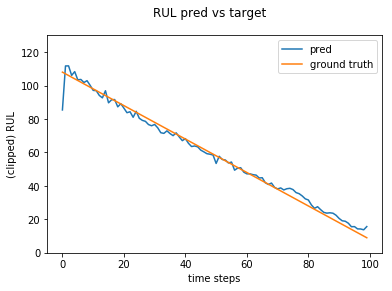

true RUL: 63


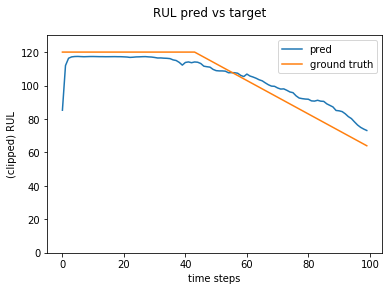

true RUL: 8


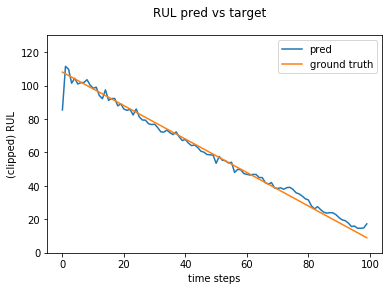

true RUL: 137


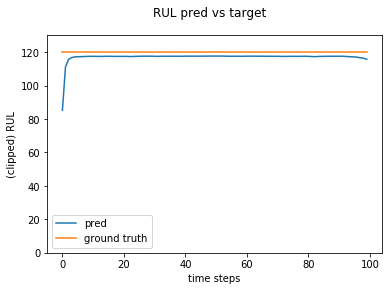

true RUL: 55


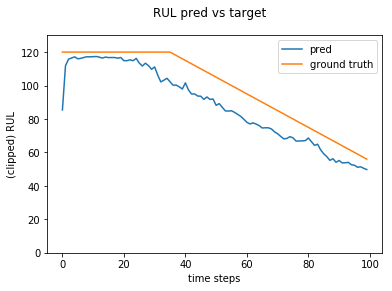

true RUL: 137


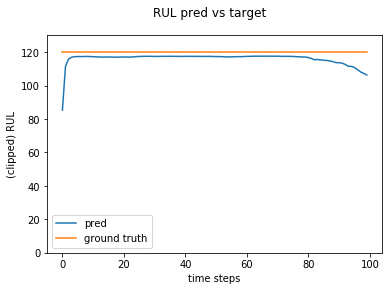

RMSE for the data is 17.413542957090357


In [40]:
# the prep_batch function is necessary to prepare a sample for inference
# for a sample longer than 100 time steps only the last 100 steps are used
# if a sample has less than 100 time steps, then the first (100-"number of timesteps of sample") steps will be filled 
# with (truncated) copies of the sample (instead of zero padding) so that the creation of the batch provided for inference 
# is 'closer' to the procedure used during traininig

def prep_batch(inp,tar): 
    length = 100
    shape = inp.shape
    mask_x = np.zeros((1,length,shape[2])).astype('float32')
    mask_y = np.zeros((length,)).astype('float32')
    if  shape[1]<=length:
        for k in range(length//shape[1]):
            mask_x[:,k*shape[1]:(k+1)*shape[1],:] = inp
            mask_y[k*shape[1]:(k+1)*shape[1]] = tar
        mask_x[:,-shape[1]:,:] = inp
        mask_y[-shape[1]:] = tar
    else:
        mask_x = inp[:,-length:,:]
        mask_y = tar[-length:]
    return mask_x,mask_y


def get_RMSE(inp=test_inp,tar=y_test,rul=RUL['rul'],plot=False,min_mode=True):
    errors = []
    ids = test_df['unit'].unique()
    for k,id_ in enumerate(ids):
        ind = test_df['unit']==id_
        x = inp[ind]
        
        unit = test_df.values[ind]
        rul_val = rul.values[k]
        y = np.minimum(120,rul_val+ind.sum()-np.arange(ind.sum()))
        
        inp_,tar_ = prep_batch(x[None,...],y)
        preds = model.predict_on_batch(inp_).numpy()
       
        if min_mode:
            pred = (preds.squeeze(0)[-10:]).min()
        else: 
            pred = preds.squeeze(0)[-1]
        errors += [(pred-rul_val)**2]
        if plot and np.random.randint(len(ids)//10)==1:
            print('true RUL:',rul_val)
            plot_Rul_vs_pred(preds.squeeze(0),tar_)
    errors = np.array(errors)
    RMSE = (errors.mean())**0.5
    print('RMSE for the data is',RMSE)
    return errors,RMSE
               
errors,RMSE = get_RMSE(plot=1)

In [39]:
print('RMSE for the data is',RMSE)

RMSE for the data is 17.413542957090357
